# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

In [1]:
'''
要使用rander 就要一开始器启动jupyter时建立一个虚拟显示器通信给jupyter用
命令为 xvfb -s "-screen 0 1400x900x24" jupyter-notebook
'''
%env THEANO_FLAGS = 'floatX=float32'
import os
print(os.environ.get('DISPLAY'))  # :1 str
print(len(os.environ.get("DISPLAY")))  # 2
'''
# 运行一个终段程序虚拟显示器0给它
if os.environ.get('DISPLAY') == ':0':
    print('create display 0')
    !bash xvfb-run -a -s "-screen 0 800x600x32" bash
    %env DISPLAY = :0

#if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    #!bash xvfb-run -a bash
    !bash xvfb-run -s "-screen 0 800x600x32"
    #!bash ../xvfb start
    %env DISPLAY = : 0
'''

env: THEANO_FLAGS='floatX=float32'
needs-to-be-defined
19


'\n# 运行一个终段程序虚拟显示器0给它\nif os.environ.get(\'DISPLAY\') == \':0\':\n    print(\'create display 0\')\n    !bash xvfb-run -a -s "-screen 0 800x600x32" bash\n    %env DISPLAY = :0\n\n#if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:\n    #!bash xvfb-run -a bash\n    !bash xvfb-run -s "-screen 0 800x600x32"\n    #!bash ../xvfb start\n    %env DISPLAY = : 0\n'

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

(4,)
[ 0.04293506 -0.0006653  -0.01832352 -0.02778047]
2


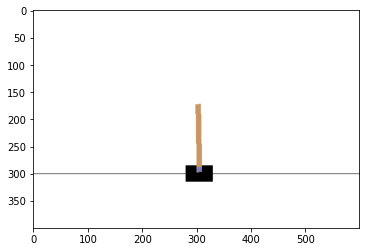

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, 'env'):
    env = env.env

s = env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(state_dim)
print(s)
print(n_actions)
plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [3]:
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
tf.keras.backend.set_floatx('float64')
'''
# 使用mxnet替代tf
import mxnet

# create input variables. We only need <s,a,R> for REINFORCE
'''
states = tf.placeholder('float32', (None,)+state_dim, name="states")
actions = tf.placeholder('int32', name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")
'''
states = s.reshape(1,-1)   # an array of 4 numbers
print(states)
actions = [0,1]  #  0 or 1
print(actions)
cumulative = None

[[ 0.04293506 -0.0006653  -0.01832352 -0.02778047]]
[0, 1]


In [10]:
'''
<define network graph using raw tf or any deep learning library >
'''
from mxnet.gluon.nn import HybridSequential as Sequential, Dense 

model = Sequential()
model.add(Dense(2, activation="relu"))
model.add(Dense(3, activation="relu"))
model.add(Dense(n_actions))
# init
model.initialize(init = mxnet.init.Xavier())

In [13]:
# utility function to pick action in one given state
from mxnet import nd

def get_action_proba(s):
    logits = model(nd.array(s))
    policy = nd.softmax(logits)
    log_policy = nd.log_softmax(logits)
    return policy, log_policy
policy, log_policy = get_action_proba(states)
print(policy)
print(log_policy)


[[0.5 0.5]]
<NDArray 1x2 @cpu(0)>

[[-0.6931472 -0.6931472]]
<NDArray 1x2 @cpu(0)>


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [48]:
# get probabilities for parti 
# 搞甘复杂的一个按索引插入张量表不如用dict,真不明白这老师的想法。
#tf.stack?
#tf.gather_nd?
'''
indices = tf.stack([tf.range(actions.shape[-1]), actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)
'''
log_policy_for_actions = {str(a):l_p for a,l_p in zip(actions, log_policy)}
print(log_policy_for_actions)

{'0': -0.6931471805599453, '1': -0.6931471805599453}


In [49]:
# REINFORCE objective function
# hint: you need to use log_policy_for_actions to get log probabilities for actions taken

# <policy objective as in the last formula. Please use mean, not sum.>
J = tf.mean(tf.sum())

SyntaxError: invalid syntax (<ipython-input-49-81e85012bcca>, line 4)

In [6]:
# regularize with entropy
entropy = <compute entropy. Don't forget the sign!>

In [7]:
# all network weights
all_weights = <a list of all trainable weights in your network >

# weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J - 0.1*entropy

update = tf.train.AdamOptimizer().minimize(loss, var_list=all_weights)

### Computing cumulative rewards

In [37]:


def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    #<your code here >
    rewards_list = []
    m = len(rewards)
    print('rewards len = {}'.format(m))
    reverse_rewards = rewards.copy()
    reverse_rewards.reverse()
    for i in np.arange(m):
        R_t = 0
        p = 0
        for r_t_1 in reverse_rewards:
            power = (m - i - p - 1)
            #print('r_t_1 = {}, power = {}'.format(r_t_1, power))
            R_t += gamma ** power * r_t_1
            p += 1
            if (m - p) == i :
                break
        #print('add one = {}'.format(R_t))
        rewards_list.append(R_t)
    #print(rewards_list)
    return rewards_list

In [39]:
#get_cumulative_rewards([i for i in range(10)])

assert len(get_cumulative_rewards([i for i in range(100)])) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")


rewards len = 100
rewards len = 7
rewards len = 7
rewards len = 7
looks good!


In [31]:
def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states: _states, actions: _actions,
                cumulative_rewards: _cumulative_rewards})

### Playing the game

In [11]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        # <pick random action using action_probas >
        a = np.random.choice(action, action_probas)

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    train_step(states, actions, rewards)

    return sum(rewards)

In [12]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):

    rewards = [generate_session() for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!")
        break

mean reward:27.590
mean reward:70.340
mean reward:129.570
mean reward:188.330
mean reward:211.530
mean reward:240.490
mean reward:235.760
mean reward:218.030
mean reward:258.470
mean reward:184.760
mean reward:298.920
mean reward:507.360
You Win!


### Results & video

In [13]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

[2017-04-08 03:29:10,315] Making new env: CartPole-v0
[2017-04-08 03:29:10,324] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-04-08 03:29:10,329] Clearing 6 monitor files from previous run (because force=True was provided)
[2017-04-08 03:29:10,336] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000000.mp4
[2017-04-08 03:29:16,834] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000001.mp4
[2017-04-08 03:29:23,689] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000008.mp4
[2017-04-08 03:29:33,407] Starting new video recorder writing to /home/jheuristic

In [14]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [ ]:
# That's all, thank you for your attention!